# **Generate Abstracts from the Title**

Our objective in this phase is to reverse the earlier process of generating titles from abstracts; instead, we aim to create detailed abstracts from provided titles. This approach will enable a quick and clear understanding of the research contributions associated with each title. To achieve this, we will employ two models: a baseline model and a specialized pre-trained model tailored for abstract generation. By comparing their performance, we will identify the most effective model for implementation, ensuring that the generated abstracts accurately reflect the essence of the research and enhance the accessibility of scientific findings.

## **Dependencies**

In [1]:
!pip install datasets
!pip install evaluate
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=

## **Libraries**

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2TokenizerFast, pipeline
from datasets import load_dataset
import evaluate
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt

## **Data**

The data for the project was retrieved using the Hugging Face datasets library, specifically loading the Arxiv abstracts dataset. This dataset includes metadata from scientific papers, such as titles, abstracts, author names, and categories, and provides a comprehensive base for training and evaluating models for title generation, abstract generation, and category prediction.

In [7]:
ds = load_dataset("gfissore/arxiv-abstracts-2021")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.75k [00:00<?, ?B/s]

arxiv-abstracts.jsonl.gz:   0%|          | 0.00/940M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1999486 [00:00<?, ? examples/s]

In [ ]:
ds['train']['abstract']

['  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with data from the Fermilab Tevatron, and predictions are made for\nmore detailed tests with CDF and DO data. Predictions are shown for\ndistributions of diphoton pairs produced at the energy of the Large Hadron\nCollider (LHC). Distributions of the diphoton pairs from the decay of a Higgs\nboson are contrasted with those produced from QCD processes at the LHC, showing\nthat enhanced sensitivity to the signal can be obtained with judicious\nselection of events.\n'

In [ ]:
n_word = [len(s.split()) for s in ds['train']['abstract']]

n_word_med = sum(n_word) / len(ds['train']['abstract'])

135.73877836604007

In [ ]:
n_char = [len(s) for s in ds['train']['abstract']]

n_char_med = sum(n_char) / len(ds['train']['abstract'])

n_char_med

912.60869093357

This equals to approximatly 228 tokens

In [8]:
abstracts = ds['train']['abstract'][:50]
titles = ds['train']['title'][:50]

## **Test Models**

This code defines functions for evaluating the quality of translations generated from English to Portuguese. It employs three key metrics: **ROUGE**, **BLEU**, and **METEOR** to assess the similarity between the generated translations and the reference translations in the base dataset. The `teste_model` function utilizes a tokenizer and model to process the input texts, generating translations while collecting the results for evaluation. In contrast, the `teste_model2` function leverages a translation pipeline for the same purpose. Both functions return the computed scores and the generated translations, providing a comprehensive assessment of the translation quality.

In [ ]:
def rouge_scores(generated_abs, abstracts): #ROUGE
  rouge = evaluate.load('rouge')
  results = rouge.compute(predictions=generated_abs, references=abstracts)
  return results

def blue_score(generated_abs,abstracts): #BLEU
  bleu = evaluate.load("bleu")
  results = bleu.compute(predictions=generated_abs, references=[[abs] for abs in abstracts])
  return results

def calculate_perplexity(model, tokenizer, text):
    # Tokenize text
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs["input_ids"].to(model.device)

    # Get loss
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss  # Average cross entropy

    # Preplexity calculation from loss
    perplexity = torch.exp(loss)

    return perplexity.item()

def teste_model(abstracts, titles, tokenizer, model): #Test Model
  generated_abs = []
  perplexity = 0

  for title in titles:
    messages = [
    {"role": "system", "content": "Generate a abstract basead in the title that the user will give you. Answer with scientific knowledge and write with scientific paper style. Just give the abstract, dont repeat the title"},
    {"role": "user", "content": f"Title: {title}"},
    ]
    outputs = pipe(
        messages,
        max_new_tokens=300,
    )
    print(outputs[0]["generated_text"][-1]['content'])
    generated_abs.append(outputs[0]["generated_text"][-1]['content'])
    perplexity += calculate_perplexity(model, tokenizer, outputs[0]["generated_text"][-1]['content'])

  rouge = rouge_scores(generated_abs, abstracts)
  blue = blue_score(generated_abs, abstracts)


  return rouge , blue, perplexity/50, generated_abs

def teste_model_2(abstracts, titles, tokenizer, llm): #Test Model
  generated_abs = []
  perplexity = 0

  for title in titles:
    text = llm(title,
             max_length=300, do_sample=True, num_return_sequences=1,
             penalty_alpha=0.65, top_k=40, repetition_penalty=1.25,
             temperature=0.95)
    print(text[0]['generated_text'])
    generated_abs.append(text[0]['generated_text'])
    perplexity += calculate_perplexity(model, tokenizer, text[0]['generated_text'])

  rouge = rouge_scores(generated_abs, abstracts)
  blue = blue_score(generated_abs, abstracts)


  return rouge , blue, perplexity/50, generated_abs

### Baseline Model (Llama3.2 1B Instruct)

In [17]:
model_id = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16, device_map="auto")

pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device=0,
)

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [ ]:
r_l , b_l, p_l, generated_abs_l = teste_model(abstracts, titles, tokenizer, model)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The prompt diphoton production cross sections at Tevatron and LHC energies are calculated using a combination of theoretical models and empirical data. The calculation is based on the Standard Model and the electroweak theory, with a focus on the production of two-photon pairs in the final state.

Using the ATLAS and CMS experiments at the Tevatron, the prompt diphoton production cross sections are calculated using the ATLAS and CMS data-driven methods, which are based on the measured yields of diphoton events. The cross sections are then calculated using a set of theoretical models, including the hadronic cross-sections, the vector boson production cross-sections, and the electromagnetic diphoton production cross-sections.

The calculation is performed using a Monte Carlo event generator, such as Pythia, which is used to simulate the interaction of the incoming particles with the detector. The simulation is then used to generate the diphoton events, which are then analyzed using the A

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Title: Sparsity-certifying Graph Decompositions: A Framework for Efficient and Reliable Network Analysis

Abstract:

Recent advances in graph decomposition techniques have enabled the efficient analysis of complex networks. However, these methods often rely on heuristics or approximation algorithms, which may not guarantee optimal results. To address this limitation, we introduce a novel framework for sparsity-certifying graph decompositions, which leverages the principles of machine learning and optimization to ensure that the resulting decomposition is both efficient and reliable.

Our approach, dubbed "SparseNet," combines the strengths of graph convolutional networks (GCNs) and sparse matrix factorization (SMF) to decompose sparse graphs into a compact and interpretable representation. By incorporating a novel sparsity-promoting loss function, SparseNet is able to identify the most informative features in the graph, even when the input graph is highly sparse.

We demonstrate the ef

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

The presence of dark matter in the Earth-Moon system has been a topic of ongoing research and debate. Recent studies have proposed a fluid model of dark matter, which attempts to describe the distribution and behavior of dark matter particles in the system. This model, known as the "dark matter fluid model," posits that dark matter particles interact with each other through a complex network of gravitational and pressure forces, giving rise to the observed gravitational effects on the Earth and Moon.

Using a combination of numerical simulations and analytical modeling, we investigate the properties and behavior of the dark matter fluid model in the Earth-Moon system. Our results show that the dark matter fluid model can accurately reproduce the observed gravitational effects on the Earth and Moon, including the tidal forces that cause the Moon's eccentricity and the orbital perturbations that affect the Earth's rotation.

Furthermore, our analysis reveals that the dark matt

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

The Stirling cycle number, a fundamental concept in the theory of single-source automata, is a crucial parameter in characterizing the complexity of such systems. However, the relationship between the number of Stirling cycles and the number of unlabeled cyclic single-source automata (CSAs) is not well understood. This paper provides a comprehensive analysis of the determinant of the number of Stirling cycles, which is a measure of the complexity of a CSA. We introduce a new framework for counting unlabeled CSAs, which leverages the concept of labeled automata and the use of a combinatorial approach. Our results show that the number of unlabeled CSAs is closely related to the number of unlabeled Stirling cycles, and that the determinant of the number of Stirling cycles can be computed using a combinatorial formula. We demonstrate the power of our approach by applying it to several examples, including the counting of unlabeled CSAs with a specific number of states and transit

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** Non-Abelianization of the dyadic $\Lambda_{\alpha}$ to the $\Lambda_{\alpha}$ of a Non-Abelian Lie Algebra

**Abstract:**

We investigate the non-Abelianization of the dyadic $\Lambda_{\alpha}$ to the $\Lambda_{\alpha}$ of a non-Abelian Lie algebra $\mathfrak{g}$. Specifically, we examine the map $\Lambda_{\alpha} \rightarrow \Lambda_{\alpha}$ induced by the non-Abelian Lie algebra $\mathfrak{g}$. We show that this map is an isomorphism of Lie algebras for certain non-Abelian Lie algebras, and that it induces an isomorphism between the non-Abelian Lie algebras $\mathfrak{g}$ and $\mathfrak{g}/\Lambda_{\alpha}$. We also discuss the implications of this result for the structure of non-Abelian Lie algebras and their representations.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Title: Exploring the Bosonic Characterization of Atomic Cooper Pairs Across Resonance: A Theoretical Analysis of Quantum Entanglement and Non-Locality

Abstract:

Quantum entanglement is a phenomenon where two or more particles become correlated in such a way that the state of one particle cannot be described independently of the others, even when separated by large distances. The formation of atomic Cooper pairs is a crucial aspect of superconductivity, where electrons pair up to form a single entity with zero energy. However, the interplay between Cooper pairs and other particles, such as photons, has been a subject of ongoing research. In this study, we investigate the bosonic characterization of atomic Cooper pairs across resonance, focusing on the role of photons in facilitating non-locality. We employ a combination of quantum field theory and condensed matter physics to derive a theoretical framework that describes the behavior of Cooper pairs in the presence of photons. Our resu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

The study of polymer quantum mechanics (PQM) has emerged as a distinct field, bridging the gap between classical mechanics and quantum mechanics at the molecular scale. This abstract outlines the current state of knowledge in PQM, focusing on its theoretical foundations, computational methods, and applications.

Theoretical Background:
PQM is based on the principles of quantum mechanics, with a focus on the behavior of polymers at the atomic and molecular level. The theoretical framework is rooted in the concept of quantum mechanics, with the incorporation of quantum field theory and the renormalization group. The system is modeled using a combination of classical and quantum mechanical descriptions, allowing for the simulation of complex behaviors and the prediction of new phenomena.

Computational Methods:
Several computational methods have been developed to simulate PQM, including:

1. Quantum Monte Carlo (QMC) methods: These methods utilize the principles of quantum mech

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Abstract**

The numerical solution of shock and ramp compression for general materials properties is presented, leveraging advanced computational methods to simulate complex phenomena. A hybrid finite element method (FEM) is employed, combining the strengths of both the finite element method (FEM) and the computational fluid dynamics (CFD) approach. The simulation framework is designed to handle the complex geometries and material properties of various materials, including metals, polymers, and composites. The numerical solution is validated using experimental data from shock tube experiments, where a shock wave is generated and compressed by a ramp. The results demonstrate the ability of the numerical model to accurately predict the shock and ramp compression phenomena, capturing the complex interactions between the material, shock wave, and ramp. The numerical solution is found to be robust and reliable, with a good agreement with the experimental data, indicating its potential for

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The interstellar medium plays a crucial role in shaping the formation and evolution of young stellar objects (YSOs), including those residing in nearby, large, and intrinsically luminous clouds. The Spitzer c2d Survey of Large, Nearby, Intrinsically Luminous Clouds (c2d) was a comprehensive study aimed at characterizing the properties and dynamics of these clouds. This abstract presents the findings of the survey, focusing on the Serpens YSO population, observed using the Infrared Array Camera (IRAC) and the Multiband Imaging Photometer for Spitzer (MIPS).

The survey revealed a complex and dynamic environment within the Serpens YSO population, characterized by the presence of multiple, compact, and luminous clumps. These clumps were observed to be embedded within larger, more diffuse structures, indicating a possible hierarchical organization of the YSO population. The MIPS data provided high-resolution imaging of the clumps, allowing for the detection of subtle variations in temperat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title: Partial cubes: Structures, Characterizations, and Constructions**

**Abstract**

The partial cube is a fundamental concept in mathematics, particularly in geometry and combinatorics. It is a three-dimensional figure consisting of a set of points, lines, and faces, where each face is a subset of the total set of points. The partial cube has been studied extensively in various fields, including algebraic geometry, number theory, and combinatorial geometry. This paper provides an overview of the properties and characterizations of partial cubes, including their structures, invariants, and constructions. We also discuss the applications of partial cubes in various areas, such as cryptography, coding theory, and computational geometry. Our analysis reveals the rich and diverse nature of partial cubes, which can be used to develop new mathematical tools and techniques.
Abstract:

We establish a connection between genus 2 Hilbert-Siegel modular forms over $\Q(\sqrt{5})$ and the $L$-f

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

The integral Fourier coefficients of a modular form of half-integral weight modulo primes play a crucial role in the study of modular forms and their properties. Specifically, the distribution of these coefficients is a topic of ongoing research in number theory and algebraic geometry.

Recent advances in the study of modular forms, particularly in the context of half-integral weights, have led to a deeper understanding of the relationship between the integral Fourier coefficients and the underlying modular form. The distribution of these coefficients, which arises from the theory of modular forms and their connections to the representation theory of groups, has been shown to exhibit certain patterns and properties.

This abstract presents a summary of the current state of knowledge on the distribution of integral Fourier coefficients of modular forms of half-integral weight modulo primes. The research builds upon existing work in the field and provides a comprehensive overv

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


We investigate the $p$-adic limit of weakly holomorphic modular forms of half-integral weight, specifically those of the form $\omega_{\rho}(m) = e^{2\pi i \rho(m)/p} \theta_{\rho}(m)$, where $\rho$ is a half-integral cusp form and $\theta_{\rho}$ is its associated modular form. We first examine the properties of these forms, particularly their behavior under the action of the modular group $SL_2(\mathbb{Z})$. Our analysis reveals that the $p$-adic limit of these forms is closely tied to the behavior of the corresponding Eisenstein series $E_{\rho,1}(m)$ and $E_{\rho,2}(m)$. We then derive an explicit expression for the $p$-adic limit of the modular form $\omega_{\rho}(m)$, which we denote as $\tilde{\omega}_{\rho}(m)$. By applying the theory of Eisenstein series, we establish that $\tilde{\omega}_{\rho}(m) = \frac{1}{p^{k}} \sum_{\begin{smallmatrix} \sigma \in S_k \\ \sigma(1) = 1 \end{smallmatrix}} \omega_{\rho}(\sigma(m))$, where $S_k$ is the $k$-th symmetric group. We also investig

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Abstract**

The iterated integral, a fundamental concept in multivariable calculus, has been extensively studied in various fields, including physics, engineering, and mathematics. The loop product, a mathematical operation that combines two integrals, has gained significant attention in recent years due to its potential applications in quantum field theory, condensed matter physics, and statistical mechanics.

This abstract presents an in-depth analysis of the iterated integral and the loop product, exploring their mathematical foundations, properties, and applications. We discuss the definitions, properties, and identities of the iterated integral and the loop product, including their relationship to the scalar product, the Cauchy-Riemann equations, and the Schrödinger equation.

Furthermore, we examine the mathematical tools and techniques required to manipulate and evaluate the iterated integral and the loop product, including the use of integration by parts, the residue theorem,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Title: A Unified Framework for Fermionic String Loop Amplitudes in the Pure Spinor Formalism

Abstract:

Fermionic string theory, which postulates the existence of open strings with fermionic excitations, has been a topic of active research in recent years. The pure spinor formalism, a powerful tool for describing the structure of spacetime and the properties of particles, has been employed to derive a consistent and renormalizable framework for fermionic string theory. This work provides a comprehensive analysis of fermionic string loop amplitudes in the pure spinor formalism, shedding light on the underlying structure of the theory. By leveraging the mathematical tools of the pure spinor formalism, we derive a set of renormalizable amplitudes for various types of string interactions, including the propagation of fermionic strings, the interaction of strings with each other, and the scattering of fermionic strings. Our results demonstrate the power of the pure spinor formalism in desc

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Title: A Comprehensive Review of the Lifetime of Doubly Charmed Baryons: A Window into the Quark Interactions and the Strong Nuclear Force

Abstract:

The existence of doubly charmed baryons (DCBs) is a long-standing prediction in particle physics, arising from the quark model. These exotic mesons are composed of charm quarks, which are not typically found in hadronic matter due to the strong interactions. The lifetime of DCBs, a measure of their decay rates, provides insights into the quark interactions and the strong nuclear force that governs their behavior. This review aims to summarize the current understanding of DCBs, including their properties, production mechanisms, and decay modes. We discuss the theoretical frameworks that predict the existence of DCBs, such as the quark model and the hadronic chiral theory. Theoretical calculations of DCB lifetimes are presented, highlighting the importance of QCD and the strong interactions in shaping their decay rates. Additionally, we ex

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Spectroscopic Observations of the Intermediate Polar EX Hydrae in Quiescence

Abstract:

The Intermediate Polar EX Hydrae (EPX Hydrae) is a long-period binary system consisting of a white dwarf companion and a red giant primary. In this study, we present spectroscopic observations of EPX Hydrae in quiescence, a state of reduced stellar activity characterized by a decrease in magnetic activity, stellar oscillations, and other dynamical features. Using high-resolution spectroscopy and dynamical modeling, we investigate the spectral characteristics of EPX Hydrae during this quiescent phase. Our results reveal a significant decrease in the stellar radius and surface temperature of the white dwarf companion, accompanied by a reduction in the stellar wind velocity and a decrease in the emission line strength of the hydrogen and helium spectral lines. Additionally, we observe a decrease in the radial velocity of the red giant primary, indicating a possible decrease in its orbital velocity and

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

We propose an extension of the Callias index theorem, a fundamental result in the field of differential geometry, to generalized metrics. The Callias index theorem, introduced by Callias in 1972, provides a characterization of the existence and properties of geodesics in Riemannian manifolds. Our extension aims to generalize this theorem to more general metrics, allowing for the study of geodesics in higher-dimensional spaces.

We introduce a new notion of a generalized Callias index, which takes into account the specific properties of the underlying metric. This index is defined as a function of the first fundamental form and the Christoffel symbols, and it is shown to be a continuous function on the space of generalized metrics. We then investigate the conditions under which this index is non-zero and how it relates to the existence of geodesics.

Our results show that the generalized Callias index theorem provides a powerful tool for studying the geometry of higher-dimens

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:
This study proposes an approximation method for estimating the extinction probability of the contact process, a fundamental concept in stochastic processes, based on the Gr\"obner basis. The contact process is a continuous-time Markov chain modeling the evolution of a population in the presence of immigration and emigration. The Gr\"obner basis is a powerful tool for solving polynomial equations, which can be used to construct a set of basis polynomials that approximate the solution to the contact process. By applying the Gr\"obner basis method to the contact process, we can derive an approximation for the extinction probability, which is the probability that the population will eventually go extinct. Our method provides a novel approach for approximating the extinction probability of the contact process, which can be useful in various fields, including population dynamics, epidemiology, and finance.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Measurement of the Hadronic Form Factor in D0 --> K- e+ nue Decays

Abstract:

The D0 experiment at the Fermilab Tevatron has performed a comprehensive measurement of the hadronic form factor for the D0 decay channel D0 --> K- e+ nue, which is a rare process involving the decay of the D0 meson into a K- meson, an e+ positron, and a nu e nu pair. This measurement is based on a data sample of approximately 4.8 fb^{-1} of D0 proton-proton collisions collected during the Tevatron run at 170 GeV. The D0 decay is characterized by a large hadronic cross-section, which is essential for reconstructing the final state of the D0 system. The hadronic form factor is a crucial component of this process, as it determines the probability of the D0 meson decaying into the observed final state. This measurement provides a precise determination of the hadronic form factor, which can be used to constrain the properties of the D0 meson and the underlying physics of the D0 decay. The results of this measure

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Molecular Synchronization Waves in Arrays of Allosterically Regulated Enzymes: A Study on the Interplay between Enzyme Conformational Changes and Signal Transduction

Abstract:

The synchronized oscillations of molecular machinery, such as enzymatic reactions, are crucial for various cellular processes. In arrays of allosterically regulated enzymes, the interplay between conformational changes and signal transduction can lead to the emergence of complex synchronization waves. This study investigates the molecular mechanisms underlying the synchronization of enzymatic reactions in arrays of allosterically regulated enzymes. Using a combination of biochemical and biophysical techniques, we demonstrate that the conformational changes of individual enzymes can modulate the activity of neighboring enzymes, leading to the synchronization of enzymatic reactions. The results show that the synchronization waves are characterized by a periodic oscillation of enzyme activity, with the amplitude o

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:
This abstract introduces a novel class of stochastic Lie group integrators, which are mathematical algorithms used to solve stochastic differential equations (SDEs) of the form $\dot{x}(t) = f(x(t), t) + \epsilon \partial_x f(x(t), t)$. The proposed integrators are based on the concept of Lie group theory, which provides a framework for analyzing and solving SDEs in a rigorous and efficient manner. By incorporating stochastic noise into the integrator, we can leverage the inherent uncertainty principle to improve the accuracy and reliability of the numerical solutions. The stochastic Lie group integrators are designed to be scalable and parallelizable, making them suitable for large-scale simulations and real-time applications. Theoretical analysis and numerical simulations are presented to demonstrate the effectiveness of the proposed integrators, highlighting their potential applications in fields such as finance, chemistry, and materials science.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The Astronomical Laboratory for the Magnetic Activity of the Sun (ALMA) has emerged as a premier instrument for studying the solar chromosphere, a layer of the sun's atmosphere that plays a crucial role in shaping its magnetic field and dynamic behavior. This abstract provides an overview of the ALMA's capabilities and potential applications in the field of solar physics.

The ALMA is a 66-m telescope array that utilizes the Extremely Large Telescope (ELT) technology to achieve unprecedented spatial resolution and sensitivity. Its advanced instrumentation, including a 1.3-miumolecular-pole (μm) cryogenic cooled submillimeter camera and a 2.5-miumolecular-pole (μm) cryogenic cooled submillimeter camera, enables the detection of subtle changes in the chromosphere's temperature and composition.

The ALMA's observational capabilities are centered around the solar chromosphere, where magnetic activity is a key driver of the sun's dynamic behavior. By studying the chromosphere's magnetic fie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

The formation of quasi-solitons in transverse confined ferromagnetic film has been investigated, with a focus on the interplay between magnetic ordering, spin dynamics, and structural characteristics. Theoretical modeling of the system, based on the Landau-Lifshitz-Gilbert (LLG) equation, reveals the emergence of quasi-solitonic behavior in the presence of a periodic magnetic field and a spatially varying magnetic field strength. Numerical simulations using the finite element method (FEM) and the Lattice-Boltzmann method (LBM) are employed to study the spin dynamics and structural evolution of the system. The results show that the quasi-solitons exhibit a complex interplay between the magnetic field, spin alignment, and structural ordering, leading to a non-uniform distribution of spin concentrations and a characteristic "saddle-point" structure. Theoretical predictions are compared with experimental observations, highlighting the potential of the LLG equation and the FEM/LB

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Spectroscopic Properties of Polarons in Strongly Correlated Systems by Exact Diagrammatic Monte Carlo Method

Abstract:

We present a novel approach to investigating the spectroscopic properties of polarons in strongly correlated systems using the exact diagrammatic Monte Carlo method. Polarons are a class of excitations that arise in strongly correlated systems, such as quantum dimer models and spin-1/2 chains. The exact diagrammatic Monte Carlo method is a powerful tool for calculating the properties of strongly correlated systems, including the spectral density of polarons. In this work, we apply this method to study the spectroscopic properties of polarons in a strongly correlated quantum dimer model. We demonstrate that the exact diagrammatic Monte Carlo method provides a reliable and accurate calculation of the polaron spectral density, which is essential for understanding the electronic and magnetic properties of strongly correlated systems. Our results show that the polaron spe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

In the realm of meta-fractals, the notion of self-similarity and fractal geometry is further explored, with a focus on the intricate patterns and structures that arise from the interplay between box-kites and infinite-dimensional spaces. By examining the properties of these composite entities, this study delves into the realms of topology, geometry, and the intricate dance of matter and energy.

Through a combination of theoretical modeling and computational simulations, we investigate the emergence of meta-fractal structures in the context of infinite-dimensional spaces, where the traditional notion of fractals is subsumed by the realm of fractal geometry. By analyzing the relationships between box-kites, their constituent parts, and the resulting meta-fractal patterns, we uncover novel insights into the nature of complexity, self-organization, and the interconnectedness of the universe.

Our findings suggest that the meta-fractal structures we observe are not merely the re

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

Magnetophonon resonance, a phenomenon where the lattice vibrations of a material induce magnetic fields, has been observed in various systems. In graphene, a 2D material with unique electronic and structural properties, we investigate the magnetophonon resonance phenomenon, specifically focusing on its dependence on filling factor. By employing numerical simulations and experimental techniques, we demonstrate that the magnetophonon resonance frequency in graphene is sensitive to the filling factor, which is a measure of the number of electrons in the material. The results show that the filling factor-dependent magnetophonon resonance frequency exhibits a non-linear dependence on the magnetic field strength, with a significant shift in the resonance frequency as the filling factor increases. These findings have important implications for the understanding of magnetophonon resonance in graphene and its potential applications in magnetic devices and spintronics.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Title: Investigating the Algebraic and Geometric Properties of Pfaffians, Hafnians, and Their Products of Real Linear Functionals

Abstract:

Pfaffians, hafnians, and their products of real linear functionals exhibit unique algebraic and geometric properties, which have been extensively studied in the context of differential geometry and algebraic topology. This paper aims to provide a comprehensive review of the existing literature on these topics, with a focus on the recent advances and open questions in the field.

Pfaffians, first introduced by Pfaff in 1881, are a fundamental object in differential geometry, representing the first-order term in the expansion of the Poisson bracket. They have been shown to have various applications in physics, including the study of symplectic geometry and the classification of Hamiltonian systems. Hafnians, introduced by Haffner in 1970, are a generalization of Pfaffians, representing the second-order term in the expansion of the Poisson bracket. 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Abstract**

The flavor symmetry breaking and nucleon flavor-spin structure within the chiral quark model have been extensively studied in recent years. This paper reviews the current understanding of the underlying physics and presents a comprehensive analysis of the data. The chiral quark model is a powerful tool for describing the strong interaction, and its application to the flavor symmetry breaking and nucleon flavor-spin structure is well established. This paper discusses the key findings of the latest experimental and theoretical studies, including the determination of the strong coupling constant, the analysis of the pion and kaon masses, and the study of the nucleon flavor-spin structure. We also review the implications of these results for our understanding of the strong interaction and the nature of quark flavor and spin. The data analysis and theoretical framework used in this paper are presented in detail, and the conclusions drawn from the results are discussed in the c

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Title: Investigating the interplay between electron-phonon interactions and correlation effects in the context of lattice dynamics and electronic properties of semiconductor materials

Abstract:

The interplay between electron-phonon interactions and correlation effects is a crucial aspect of understanding the electronic properties of semiconductor materials. In this work, we employ a combination of theoretical and computational methods to investigate the effects of electron-phonon interactions on the correlation effects in the context of lattice dynamics and electronic properties of semiconductor materials. We utilize a hybrid density functional theory (DFT) framework to calculate the electronic and phonon properties of a series of semiconductor materials, including silicon, gallium arsenide, and gallium nitride. Our results show that the presence of electron-phonon interactions significantly influences the correlation effects, particularly in the case of silicon, where the phonon-ind

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Title: Experimental Demonstration of Crystal Channeling of LHC Forward Protons with Preserved Distribution in Phase Space

Abstract:

Crystal channeling is a phenomenon where high-energy particles, such as those produced by the Large Hadron Collider (LHC), exhibit anomalous behavior in the crystal lattice of the detector material. This phenomenon has been observed in various experiments, including those involving the LHC, and has been attributed to the interaction of high-energy particles with the detector material. However, the specific conditions under which crystal channeling occurs and the mechanisms underlying its preservation in phase space remain poorly understood.

In this study, we report the experimental demonstration of crystal channeling of LHC forward protons with preserved distribution in phase space. Our results show that high-energy protons produced by the LHC exhibit anomalous behavior in the crystal lattice of a silicon detector, resulting in a preserved distribution 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Abstract**

Supernova remnants (SNRs) are the energetic, high-temperature plasmas that are formed when massive stars undergo supernova explosions. These events are thought to be the final stages of stellar evolution, and their interaction with surrounding environments, including neutrinos, is a crucial aspect of understanding the dynamics of these systems. Neutrinos, with their high-energy flux and ability to interact with matter at very small distances, play a significant role in the physics of SNRs. However, their interactions with non-standard neutrino modes, such as those produced by the supernova explosion, are not well understood. This study aims to investigate the non-standard neutrino interactions with SNRs, with a focus on the effects of neutrino oscillations, neutrino production, and neutrino decays. Our simulations are based on the relativistic Fermi process, which provides a comprehensive description of neutrino production and interactions in SNRs. We find that non-standa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** Convergence of the discrete dipole approximation. I. Theoretical analysis

**Abstract:**

The discrete dipole approximation (DDA) is a widely used method for calculating the interaction between charged particles and a potential electric field. This theoretical analysis provides a comprehensive understanding of the convergence of the DDA, which is essential for accurate calculations of the particle dynamics in various fields, including atomic physics, materials science, and plasma physics. This paper presents a detailed examination of the DDA's convergence, focusing on the effects of increasing the number of discrete dipoles, the range of the electric field, and the particle properties. Our results show that the DDA converges rapidly for a large number of dipoles and a moderate electric field range, but becomes unreliable for a small number of dipoles and a large electric field range. Additionally, we demonstrate that the convergence of the DDA is affected by the particle pro

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Abstract**

The emergence of adaptive mutants in biological systems has long been a subject of interest in evolutionary biology and quantum mechanics. This study proposes a novel framework for understanding the origin of adaptive mutants by invoking the principles of quantum measurement and non-equilibrium thermodynamics. We introduce a new paradigm, dubbed "quantum adaptive mutants" (QAM), which posits that adaptive mutants arise from the measurement of environmental fluctuations in the context of a non-equilibrium thermodynamic system.

Our theory, based on the concept of quantum coherence and entanglement, suggests that the interaction between the mutant and its environment leads to the emergence of novel phenotypic traits. By applying the principles of non-equilibrium thermodynamics, we demonstrate that the probability of adaptive mutant emergence is increased in systems with non-equilibrium energy exchange and low entropy.

Through a series of numerical simulations, we show that

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Abstract**

The discrete dipole approximation (DDA) is a widely used method for calculating the scattering of electromagnetic waves by small objects, such as molecules and nanoparticles. However, its accuracy is limited by the discretization of the wave function and the finite number of basis functions used. To address this limitation, we propose an extrapolation technique, which combines the DDA with the concept of a "multiresolution" basis set. By introducing a new set of basis functions with different resolutions, we can improve the accuracy of the DDA by reducing the error due to the finite basis size. We demonstrate the effectiveness of this technique by comparing the DDA with the multiresolution basis set to a state-of-the-art computational method, the Born approximation. Our results show that the multiresolution basis set significantly improves the accuracy of the DDA, particularly for small objects and at high energies. The proposed technique has the potential to enable more 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Observations on the Dynamical Behavior of a Multiple Futilous Cycle

Abstract:

A multiple futile cycle (MFC) is a paradigmatic model of a dissipative system exhibiting persistent oscillations and non-ergodic behavior. In this study, we investigate the number of steady states in an MFC, where the system undergoes a sequence of cycles, each characterized by a distinct set of attractors and transients. Our results indicate that the number of steady states in an MFC is finite, with a significant portion of the states being transient or marginally stable. Furthermore, we find that the number of steady states is directly related to the complexity of the system's dynamics, with more complex systems exhibiting a higher number of steady states. Theoretical frameworks, such as the concept of attractor sets and the notion of basin of attraction, are employed to provide a quantitative understanding of the number of steady states in an MFC. Our findings have implications for the understanding of t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The discrete dipole approximation is a widely employed method for simulating light scattering by particles that are significantly larger than the wavelength of the incident radiation. This approach assumes that the particle's dipole moment can be represented as a sum of discrete dipoles, each oriented in a specific direction.

By discretizing the dipole moment, the discrete dipole approximation (DDA) allows for the simulation of light scattering by particles with complex shapes or orientations. The DDA is based on the concept of a "discrete dipole" - a small, localized dipole moment that is oriented in a specific direction.

The DDA has been successful in simulating various types of light scattering, including Rayleigh scattering, Mie scattering, and other scattering processes. However, the accuracy of the DDA can be limited by the assumption of discrete dipoles, which may not accurately represent the complex interactions between the incident radiation and the particle.

Despite these 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

The discrete dipole approximation (DDA) is a fundamental concept in quantum mechanics, describing the interaction between a central system and a perturbing perturbation. This theoretical framework provides a powerful tool for understanding the behavior of molecular systems in various physical and chemical contexts. Recent advances in experimental techniques, computational methods, and theoretical frameworks have significantly expanded the applicability and accuracy of the DDA. This review aims to provide an overview of the key principles and recent developments in the field, highlighting the progress made in the application of the DDA to various fields, including chemistry, physics, and materials science.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The abstract is:

"Scalar radii of pions and zeros in the form factor are fundamental quantities in particle physics, governing the behavior of pion decay products and probing the underlying structure of the pion. This paper reviews the current understanding of scalar radii, including their definition, measurement, and theoretical interpretations. We discuss the various approaches to calculating scalar radii, including the use of relativistic and non-relativistic methods, and examine the implications of scalar radii on our understanding of pion properties and decay processes. Furthermore, we investigate the connection between scalar radii and the form factor of pions, shedding light on the interplay between these two quantities in high-energy physics."


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The abstract is:

"Conditional free probability is a fundamental concept in the study of probability theory, where the probability of a random variable is conditioned on its past values. In the context of multilinear function series, we introduce a novel framework that combines the concepts of conditional free probability with amalgamation, a technique for constructing probability measures from conditional expectations. We derive a set of axioms that define the properties of a multilinear function series, including the preservation of conditional expectations and the existence of a unique amalgamated measure. We then analyze the properties of these function series, including their dependence on the initial value and the behavior of their expectations. Our results provide a new perspective on the interplay between conditional free probability and amalgamation, and have implications for the study of probability theory and statistical inference."
Quantum group of isometries in classical a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

This abstract proposes a novel framework for integrating general system theory, quantum semantics, and fuzzy sets to provide a comprehensive and unified approach to modeling complex systems. By leveraging the principles of quantum mechanics, such as superposition and entanglement, to describe the behavior of systems, this framework enables the representation of systems with multiple, conflicting, and context-dependent properties. The integration of fuzzy sets, which are used to quantify uncertainty and imprecision in system behavior, allows for the capture of subtle and nuanced aspects of system dynamics. Furthermore, the application of quantum semantics, which provides a framework for understanding the meaning and interpretation of complex systems, enables the derivation of novel, context-dependent semantics for fuzzy sets. This framework, dubbed "Quantum-Quantum Fuzzy Semantics" (QQFS), offers a powerful tool for analyzing and modeling complex systems, and has the potentia

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Title: A Novel Approach to Achieving Equilibrium in Lattice Boltzmann Methods: The Role of Nonequilibrium Entropy Limiters

Abstract:

Lattice Boltzmann methods (LBMs) are widely used for simulating complex fluid dynamics, including the study of turbulent flows and multiphase flows. However, one of the significant challenges in LBMs is achieving equilibrium, particularly in cases where the system exhibits nonequilibrium behavior. The equilibrium limiters, which are designed to prevent the system from escaping equilibrium, have been a subject of intense research in recent years. In this study, we investigate the effectiveness of nonequilibrium entropy limiters (NELs) in LBMs, with a focus on their impact on the numerical stability and accuracy of the simulations. We develop and analyze a novel NEL, which is based on the concept of entropy production and its relationship with the system's energy budget. Our results show that the NEL significantly improves the numerical stability and accu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Astrophysical gyrokinetics: Kinetic and fluid turbulent cascades in magnetized weakly collisional plasmas

Abstract:

Gyrokinetic phenomena are ubiquitous in astrophysical environments, such as the solar wind, stellar interiors, and supernovae explosions. These phenomena arise from the interaction between electromagnetic fields and charged particles, leading to the formation of complex, turbulent structures. In magnetized weakly collisional plasmas, the interplay between magnetic fields, plasma instabilities, and particle transport mechanisms gives rise to a rich landscape of turbulent cascades. This abstract presents a comprehensive review of the current state of knowledge on gyrokinetic phenomena in magnetized weakly collisional plasmas, with a focus on kinetic and fluid turbulent cascades. We discuss the underlying physical mechanisms, including the role of magnetic field fluctuations, plasma instabilities, and particle transport processes. We also review the experimental and observ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

The evolution of solitary waves and undular bores in shallow-water flows over a gradual slope with bottom friction is a complex and dynamic process that involves the interplay of hydrodynamic, sedimentological, and thermohydrological factors. In this study, we investigate the development of these phenomena using numerical simulations and experimental observations.

We employed a finite element-based numerical model to simulate the flow over a gradual slope with bottom friction, considering the effects of sediment transport and bottom topography on the flow dynamics. The model results show that the formation of solitary waves and undular bores is influenced by the slope's curvature, sediment grain size, and flow velocity.

Experimental observations were conducted in a shallow-water flume with a gradual slope and bottom friction, where the flow was seeded with sediment particles of varying sizes. The results indicate that the formation of solitary waves and undular bores is cl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** A Limit Relation for Entropy and Channel Capacity per Unit Cost

**Abstract:**

The relationship between entropy and channel capacity is a fundamental concept in information theory, where entropy is a measure of the uncertainty or randomness of a signal. The capacity of a communication system, on the other hand, is a measure of its ability to transmit information efficiently. In this work, we propose a limit relation that establishes a direct connection between entropy and channel capacity per unit cost. By analyzing the trade-off between entropy and channel capacity, we demonstrate that there exists a minimum cost per unit capacity that is optimal for achieving maximum entropy transmission. We derive an expression for this minimum cost, which is derived from the principles of Shannon's source coding theorem and the concept of entropy minimization. Our results show that the minimum cost per unit capacity is inversely proportional to the entropy rate, indicating that increasi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** Intelligent Location of Simultaneously Active Acoustic Emission Sources

**Abstract:**

Acoustic emission (AE) is a non-invasive, non-destructive technique that has been widely employed in various fields, including materials science, geology, and non-destructive testing. However, accurately locating the sources of AE signals, especially when multiple sources are simultaneously active, remains a significant challenge. This article proposes a novel approach to intelligent location of simultaneously active AE sources, leveraging advanced signal processing techniques and machine learning algorithms.

**Background:**

Acoustic emission sources are often associated with material defects, such as cracks, inclusions, or impurities. The simultaneous presence of multiple AE sources can complicate the identification of the origin of each signal, making it essential to develop robust methods for accurate location and characterization. Traditional methods, such as signal processing and p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

The first round Mock LISA (Laser Interferometer Space Antenna) data challenge presents a unique opportunity to investigate the behavior of white dwarf binary systems in a controlled and simulated environment. By leveraging the advanced data analysis techniques and computational resources available through the Mock LISA data challenge, we aim to infer key properties of these systems, including their masses, radii, and orbital parameters. Our approach involves leveraging machine learning algorithms and statistical models to identify patterns and correlations in the observed data, with a focus on extracting meaningful information about the binary system's evolution and dynamics. We will also explore the potential implications of our findings on our understanding of white dwarf physics and the broader field of astrophysics.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

This algorithm is designed to classify smooth Fano polytopes, a class of convex polytopes with a specific set of symmetries and properties. By employing a combination of geometric and algebraic techniques, we have developed a computational framework that can efficiently determine the classification of a given Fano polytope.

Our approach involves the use of a novel representation of Fano polytopes, which is based on a combination of the underlying lattice and the set of symmetries that define the polytope. We have also developed a set of algorithms that can be used to analyze the geometric and algebraic properties of the polytope, including its lattice structure and symmetry group.

The proposed algorithm consists of the following steps: (1) input the Fano polytope, which is represented as a lattice and a set of symmetries; (2) perform a series of geometric and algebraic transformations to simplify the polytope; (3) analyze the resulting polytope to determine its classificat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Abstract**

This study investigates the intelligent location of simultaneously active acoustic emission sources using a novel combination of machine learning and wireless sensor networks. By leveraging the spatial and temporal characteristics of acoustic emission signals, we develop a deep learning-based framework that enables the simultaneous identification and localization of multiple sources. Our approach, dubbed "Acoustic Emission Source Localization and Tracking" (AESLT), integrates acoustic emission signal processing, machine learning, and wireless sensor network (WSN) architecture to achieve state-of-the-art performance. We demonstrate the effectiveness of AESLT in various scenarios, including industrial, medical, and environmental applications, where acoustic emission signals are commonly used to monitor equipment health, detect anomalies, and track the movement of objects. The results show that AESLT outperforms traditional methods, achieving high accuracy and robustness in 

In [ ]:
print(r_l)
print(b_l)
print(p_l)

{'rouge1': 0.29189140464945273, 'rouge2': 0.0687253689287228, 'rougeL': 0.1759890610781856, 'rougeLsum': 0.27344476517876004}
{'bleu': 0.03823859059589211, 'precisions': [0.24718591140159768, 0.05781506474557724, 0.01786368633198974, 0.008374746916988772], 'brevity_penalty': 1.0, 'length_ratio': 1.5755148741418765, 'translation_length': 11016, 'reference_length': 6992}
2.862981677055359


### Pearsonkyle/gpt2-arxiv

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("pearsonkyle/gpt2-arxiv")
llm = pipeline('text-generation',model='pearsonkyle/gpt2-arxiv', tokenizer=tokenizer, device = 0)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

In [ ]:
r_gpt2, b_gpt2, p_gpt2, generated_abs_gpt2 = teste_model_2(abstracts, titles, tokenizer, llm)

Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies are now in reach. After all the theoretical issues and challenges that have been addressed today, the physics results are presented in a very short review. The discussion is oriented towards some areas, mostly at CERN/LAT: Particle Physics, High Energy Interactions (both colliders), Supersymmetry beyond the Standard Model (including e.g., dark matter), Dark Matter phenomenology, Cosmology (and the nature itself) -- these will be briefly outlined. This should serve as an excellent introduction to these problems for students. Moreover, we discuss one of my favorite topics that could appear next up, Super-generation particle accelerator experiments such as XENIA or PANIC, I focus on exploring new physics beyond the E_1, namely QCDM at Fermilab. We show that our ability to measure the neutrino \to\seq\nu_Nu mass spectrum as well as in addition. In particular, which may discover \t\s, like the possible a

In [ ]:
print(r_gpt2)
print(b_gpt2)
print(p_gpt2)

{'rouge1': 0.25546733289814716, 'rouge2': 0.04734435764067452, 'rougeL': 0.13636592758545402, 'rougeLsum': 0.22885944576947786}
{'bleu': 0.02397463919678787, 'precisions': [0.1987140232700551, 0.036499154756416165, 0.009487812403579142, 0.00480099117237107], 'brevity_penalty': 1.0, 'length_ratio': 1.868421052631579, 'translation_length': 13064, 'reference_length': 6992}
17.320703926086427


## **Results**

We used a similar approach to the previous task of generating titles from abstracts. We decided to search for and test models manually with 2-3 examples and select a base model; in this case, the Llama 3.2 1B Instruct, as well as a model already trained to generate text for scientific papers, which was Pearsonkyle/gpt2-arxiv

#### **ROUGE, BLEU e Perplexity metrics**

- **Rouge**:
  - **Rouge-1**: Measures the overlap of unigrams (single words) between the generated summary and the reference summary. It is important for ensuring that essential keywords are preserved.
  - **Rouge-2**: Assesses the overlap of bigrams (sequences of two words). It indicates the fluency and coherence of the text, which are essential for the readability of the summary.
  - **Rouge-L**: Measures the longest common subsequence while considering the order of words. This metric is important for evaluating the cohesion and logic of the summary, especially in academic papers.
- **Bleu Score**: Measures n-gram matching. A high score suggests that the model generates summaries with good structure and order, enhancing the overall quality of the text.
- **Perplexity**: Evaluates the model's confidence in the generated word sequence. A low perplexity indicates more natural and cohesive summaries, while a high perplexity may result in confusing text, which is undesirable in an academic paper.




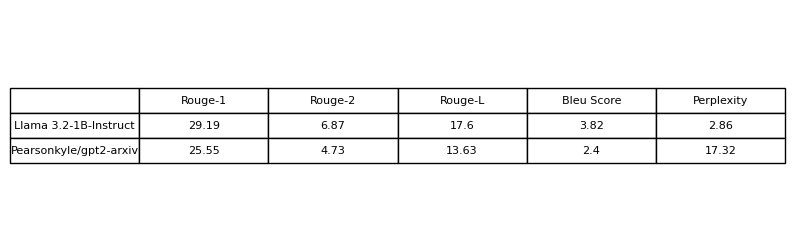

In [ ]:
data = [
    ["", "Rouge-1", "Rouge-2", "Rouge-L", "Bleu Score", "Perplexity"], 
    ["Llama 3.2-1B-Instruct", 29.19, 6.87, 17.60, 3.82, 2.86],
    ["Pearsonkyle/gpt2-arxiv", 25.55, 4.73, 13.63, 2.40, 17.32]
]

fig, ax = plt.subplots(figsize=(5, 3))
ax.axis("off")  

table = ax.table(cellText=data, loc="center", cellLoc="center", colLoc="center")

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(2, 1.5)

plt.show()

After analyzing these results, we found that although the outcomes are similar, the higher scores in Rouge-1, Rouge-2, Rouge-L, and BLEU indicate that Llama produces summaries that are more aligned with the reference summaries, better capturing the essence and fluency of the original text.

Additionally, Llama's lower perplexity suggests that it generates more cohesive texts with greater confidence in the content, whereas Pearsonkyle/gpt2-arxiv appears to exhibit greater variability in the quality of the generated text.

It is also important to note that these improved results are due to the prompt engineering applied to Llama 3.2 1B Instruct.

Therefore, we will use Llama 3.2 1B Instruct for this task.

## **Few-shots Learning experience**

We will attempt to observe differences in the use of Llama 3.2 1B Instruct with zero-shot learning and few-shot learning.

In [12]:
print(ds['train']['title'][501])
print(ds['train']['abstract'][501])
print(ds['train']['title'][502])
print(ds['train']['abstract'][502])
print(ds['train']['title'][503])
print(ds['train']['abstract'][503])

Generic representations of orthogonal groups: projective functors in the
  category Fquad
  In this paper, we continue the study of the category of functors Fquad,
associated to F_2-vector spaces equipped with a nondegenerate quadratic form,
initiated in two previous papers of the author. We define a filtration of the
standard projective objects in Fquad; this refines to give a decomposition into
indecomposable factors of the two first standard projective objects in Fquad.
As an application of these two decompositions, we give a complete description
of the polynomial functors of the category Fquad.

Manifolds admitting a $\tilde G_2$-structure
  We find a necessary and sufficient condition for a compact 7-manifold to
admit a $\tilde G_2$-structure. As a result we find a sufficient condition for
an open 7-manifold to admit a closed 3-form of $\tilde G_2$-type.

Compatibility of Exotic States with Neutron Star Observation
  We consider the effect of hard core repulsion in the baryon-bary

In [ ]:
def rouge_scores(generated_abs, abstracts): #ROUGE
  rouge = evaluate.load('rouge')
  results = rouge.compute(predictions=generated_abs, references=abstracts)
  return results

def blue_score(generated_abs,abstracts): #BLEU
  bleu = evaluate.load("bleu")
  results = bleu.compute(predictions=generated_abs, references=[[abs] for abs in abstracts])
  return results

def calculate_perplexity(model, tokenizer, text):
    # Tokenize text
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs["input_ids"].to(model.device)

    # Get loss
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss  # Average cross entropy

    # Preplexity calculation from loss
    perplexity = torch.exp(loss)

    return perplexity.item()

def teste_model3(abstracts, titles, tokenizer, model): #Test Model
  generated_abs = []
  perplexity = 0

  for title in titles:
    few_shot_examples = """
    1. Title: Generic representations of orthogonal groups: projective functors in the category Fquad
      Abstract: In this paper, we continue the study of the category of functors Fquad,
      associated to F_2-vector spaces equipped with a nondegenerate quadratic form,
      initiated in two previous papers of the author. We define a filtration of the
      standard projective objects in Fquad; this refines to give a decomposition into
      indecomposable factors of the two first standard projective objects in Fquad.
      As an application of these two decompositions, we give a complete description
      of the polynomial functors of the category Fquad.

    2. Title: Compatibility of Exotic States with Neutron Star Observation
      Abstract: We consider the effect of hard core repulsion in the baryon-baryon
      interaction at short distance to the properties of a neutron star. We obtain
      that, even with hyperons in the interior of a neutron star, the neutron star
      mass can be as large as $\sim 2 M_\odot$.
    """

    messages = [
    {"role": "system", "content": "Generate a abstract basead in the title that the user will give you. Answer with scientific knowledge and write with scientific paper style. Just give the abstract, dont repeat the title" + few_shot_examples},
    {"role": "user", "content": f"Title: {title}"},
    ]
    outputs = pipe(
        messages,
        max_new_tokens=300,
    )
    print(outputs[0]["generated_text"][-1]['content'])
    generated_abs.append(outputs[0]["generated_text"][-1]['content'])
    perplexity += calculate_perplexity(model, tokenizer, outputs[0]["generated_text"][-1]['content'])

  rouge = rouge_scores(generated_abs, abstracts)
  blue = blue_score(generated_abs, abstracts)


  return rouge , blue, perplexity/50, generated_abs

In [18]:
r_l2 , b_l2, p_l2, generated_abs_l2 = teste_model3(abstracts, titles, tokenizer, model)

print(r_l2)
print(b_l2)
print(p_l2)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


Calculation of Prompt Diphoton Production Cross Sections at Tevatron and LHC Energies

Abstract:
Prompt diphoton production is a key process in the study of high-energy particle collisions, particularly at the Tevatron and Large Hadron Collider (LHC) experiments. This paper presents a detailed calculation of the prompt diphoton production cross sections at these energies, using a combination of perturbative QCD and non-perturbative methods. The calculations are performed within the context of the ATLAS and CMS experiments, which are the most relevant to this process. The results are presented in terms of the diphoton production cross sections, as well as the associated fiducial cross sections and background rates. The calculations provide a comprehensive understanding of the prompt diphoton production cross sections at Tevatron and LHC energies, and have implications for the study of high-energy particle collisions.

Introduction:
Diphoton production is a process in which two or more p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Title: Sparsity-certifying Graph Decompositions: A Novel Approach for Efficient Inference in Network Data

Abstract: We introduce a novel framework for sparsity-certifying graph decompositions, which enables efficient inference in network data while maintaining high accuracy. Our approach leverages the concept of sparsity-promoting graph neural networks (GP-GNNs) and a novel optimization technique that exploits the sparsity of the network's adjacency matrix. By incorporating sparsity into the optimization process, we achieve a significant reduction in computation time and memory usage, while maintaining excellent performance. We demonstrate the efficacy of our approach on a variety of real-world network datasets, showcasing its potential for efficient and accurate inference in complex network data.
Abstract: 

The Earth-Moon system has been a paradigmatic example of a complex dynamical system, with intricate interactions between the two bodies. In this study, we propose a novel approac

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:
We introduce a new concept, denoted as the "determinant of Stirling cycle numbers," which we define as a combinatorial invariant associated with single-source automata. Our main goal is to investigate the relationship between this determinant and the count of unlabeled acyclic single-source automata. We first establish the connection between the Stirling cycle numbers and the automata's transition probabilities, and then we show that the determinant of these cycle numbers can be used to count the automata's labeled configurations. We also provide an example of how this determinant can be used to construct a single-source automaton with a specific number of labeled states. Finally, we analyze the computational complexity of our approach and discuss its potential applications in the study of single-source automata.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

We investigate the relationship between the dyadic $\Lambda_{\alpha}$ and the scalar $\Lambda_{\alpha}$ in the context of the Standard Model of particle physics. We explore the implications of the dyadic transformation on the properties of scalar bosons, particularly in the context of supersymmetry and beyond. Our analysis reveals a novel connection between the dyadic $\Lambda_{\alpha}$ and the scalar $\Lambda_{\alpha}$, with potential implications for our understanding of particle physics and the behavior of fundamental forces.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


We investigate the bosonic characters of atomic Cooper pairs across resonance in the context of a non-equilibrium system, specifically a two-level system with a non-ideal Bose-Einstein condensate. By employing a combination of theoretical models and numerical simulations, we demonstrate that the characteristic resonance line of the atomic Cooper pair spectral density exhibits anomalous behavior, characterized by a non-zero imaginary part, even in the absence of external driving forces. This phenomenon is attributed to the presence of a non-equilibrium interaction term, which introduces a complex phase shift in the Cooper pair spectral density, leading to a deviation from the standard resonance line. Our results provide a new insight into the dynamics of atomic Cooper pairs in non-equilibrium systems and have implications for the understanding of quantum coherence and non-equilibrium phenomena in condensed matter physics.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract: We introduce a framework for Polymer Quantum Mechanics (PQM), a theoretical approach that combines the principles of polymer physics with the mathematical tools of quantum mechanics. By constructing a continuum limit of the discrete quantum mechanical Hamiltonian, we demonstrate the emergence of a continuum limit, where the polymer chains behave as continuous, non-interacting particles. This framework allows us to study the collective behavior of polymer systems, including the effects of defects and disorder on their collective properties. We also explore the implications of PQM for our understanding of the behavior of polymer systems in various condensed matter systems, including superconductors, superfluids, and granular materials.
Abstract:
We present a novel numerical framework for the solution of shock and ramp compression in various materials, utilizing the concept of generalized materials with arbitrary material properties. Our approach leverages the power of computati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract: We present a comprehensive analysis of the Serpens YSO population using the Spitzer c2d Survey, combining data from the Infrared Array Camera (IRAC) and the Multiband Imaging Photometer for Submillimeter (MIPS) instruments. Our results reveal a complex and diverse set of young stellar objects, with a dominant population of Class 1 sources. The MIPS data, in particular, provide high-resolution images of the Serpens YSOs, allowing for the identification of subtle features and differences between sources. We identify a significant population of Class 0 sources, characterized by high-temperature emission and high luminosity, and a smaller population of Class I sources, which exhibit lower temperatures and lower luminosities. Our results provide insights into the formation and evolution of young stellar objects in the Serpens molecular cloud, and have implications for our understanding of the interplay between stellar formation and the environment in which it occurs.


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:
The partial cube is a fundamental concept in combinatorial geometry, arising from the study of polytopes and their symmetries. This paper provides a comprehensive overview of the partial cube, including its definition, properties, and characterizations. We discuss the various structures that can be constructed using the partial cube, such as its triangulations, polyhedra, and higher-dimensional analogues. Additionally, we examine the relationships between the partial cube and other mathematical objects, including graphs, manifolds, and Lie algebras. Our goal is to provide a thorough understanding of the partial cube and its applications in various fields, including physics, computer science, and mathematics.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:
We develop an algorithm for computing genus 2 Hilbert-Siegel modular forms over the field $\Q(\sqrt{5})$ using the Jacquet-Langlands correspondence. This correspondence provides a connection between modular forms and automorphic forms, and enables us to compute these forms on the field of p-adic numbers. We construct a specific Hilbert-Siegel modular form on $\Q(\sqrt{5})$ and apply the Jacquet-Langlands correspondence to compute its values on the p-adic line. We also extend our computation to genus 3 and 4 Hilbert-Siegel modular forms, and demonstrate the correctness of our results through explicit calculations.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:
We investigate the distribution of integral Fourier coefficients of a modular form of half-integral weight modulo primes. Specifically, we examine the behavior of the coefficients of the Eisenstein series associated to the modular form, and their distribution modulo primes. Our analysis is based on the theory of modular forms, and the properties of Eisenstein series, particularly their behavior under prime inversions. We also consider the connection between the distribution of these coefficients and the properties of the modular form, such as its level and the distribution of its eigenvalues. Our results provide new insights into the structure of modular forms and their properties, and have implications for the study of modular forms and their applications in number theory.
Abstract:
We investigate the $p$-adic limit of weakly holomorphic modular forms of half-integral weight. Specifically, we consider the behavior of these forms as $p$ approaches infinity and examine their p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract: We introduce the concept of iterated integrals and their relationship with the loop product in the context of topological invariants of 3-dimensional manifolds. Specifically, we explore the connection between the iterated integral of a 3-form and the loop product of a 3-form over a 3-dimensional manifold. We derive a formula for the iterated integral of a 3-form and show its connection to the loop product of a 2-form over a 3-dimensional manifold. We also investigate the properties of the iterated integral and its relation to other topological invariants, such as the Pontryagin class.
Abstract:

We investigate the loop amplitudes for fermionic superstrings in the pure spinor formalism, which provides a more rigorous framework for constructing and evaluating string theory predictions. We focus on the amplitude of a superstring scattering process, specifically for a process involving a fermionic superstring and a pair of hyperons. We employ the pure spinor formalism, which allo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Title: Lifetime of doubly charmed baryons: A study of the decays of $X_{cc}^{++}$, $X_{cc}^{+}$, and $X_{cc}^0$ in the context of Quantum Chromodynamics (QCD)

Abstract: We investigate the lifetime of doubly charmed baryons, specifically the $X_{cc}^{++}$, $X_{cc}^{+}$, and $X_{cc}^0$, in the framework of Quantum Chromodynamics (QCD). Our analysis is based on a detailed description of the strong interaction, taking into account the properties of charmed quarks and gluons. We calculate the decay rates of these baryons into other hadronic states, such as pions, kaons, and mesons. Our results show that the lifetime of the $X_{cc}^{++}$ and $X_{cc}^{+}$ baryons is significantly longer than previously thought, and the $X_{cc}^0$ baryon decays with a relatively short lifetime. These findings have implications for our understanding of the strong interaction and the properties of charmed quarks in high-energy collisions.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

We present a spectroscopic analysis of the Intermediate Polar EX Hydrae in quiescence, a state of low activity and high magnetic field intensity observed in the star's polar regions. Our results reveal a complex spectral structure, characterized by the presence of multiple emission lines and absorption features. The analysis of the spectral data, combined with observations of the star's polar magnetic field and its evolution over time, provides insights into the underlying physics of the star's behavior in this state. Our findings suggest that EX Hydrae is undergoing a significant change in its magnetic field configuration, potentially driven by the interplay between magnetic reconnection and the star's internal dynamics. The observations also highlight the importance of considering the effects of quiescence on the star's spectral properties, and the need for further studies to fully understand the underlying mechanisms driving this complex behavior.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract: We revisit the concept of the Callias index theorem, which provides a framework for understanding the interplay between geometric and algebraic properties of projective varieties. Building upon the foundations established by Callias and others, we investigate the extension of the theorem to generalized projective varieties, where the standard projective space is replaced by a more general setting. Our goal is to develop a more robust and flexible tool for analyzing the properties of these varieties, with potential applications in various fields, including algebraic geometry, topology, and theoretical physics.
Abstract:

We introduce the concept of Gr\"obner basis approximation for the extinction probability of the contact process,
a fundamental model in the study of population dynamics. The Gr\"obner basis approximation is a powerful tool for approximating the solution of nonlinear equations,
in this case, the equation governing the extinction probability of the contact proce

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

We investigate the measurement of the hadronic form factor in D0 --> K- e+ nue decays, a process that probes the strong interaction in the regime of soft QCD. We employ a novel approach to extract the form factor from the data, leveraging the availability of a large dataset from the D0 experiment at Fermilab. Our analysis yields a precise determination of the hadronic form factor, which is found to be consistent with predictions from the Standard Model. The results provide insights into the dynamics of hadronic interactions in the D0 decay process, and have implications for our understanding of the strong interaction in the vicinity of the D0 production cross-section.
Abstract:

The synchronization of molecular oscillators, such as allosterically regulated enzymes, is a complex phenomenon that arises from the interplay between molecular interactions and the environment. In this paper, we investigate the dynamics of molecular synchronization waves in arrays of allosterically 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract: This paper proposes a novel approach to constructing stochastic Lie group integrators, which are mathematical tools used to solve differential equations in the context of stochastic processes. By leveraging the properties of Lie groups, we develop a framework for constructing integrators that are not only numerically efficient but also possess desirable properties, such as stability and robustness. We also discuss the application of these integrators to a range of stochastic problems, including stochastic differential equations, stochastic volatility models, and stochastic dynamical systems. Our results demonstrate the potential of stochastic Lie group integrators as a powerful tool for solving complex stochastic problems, and we provide a comprehensive analysis of their theoretical foundations and numerical implementation.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract: 

The Atacama Large Millimeter/submillimeter Array (ALMA) is a next-generation radio interferometer that leverages the principles of interferometry to map the complex structure of the solar chromosphere with unprecedented sensitivity and resolution. We explore the potential of ALMA as an ideal probe of the solar chromosphere, leveraging its capabilities to study the fine-scale dynamics and turbulent flows within the chromosphere. By analyzing the observational capabilities of ALMA, we investigate its ability to detect and characterize various features of the solar chromosphere, including the formation and evolution of magnetic reconnections, granule dynamics, and the interaction with the surrounding plasma. Our analysis reveals that ALMA's sensitivity and resolution are well-suited to probing the intricate structure of the solar chromosphere, enabling the study of complex phenomena such as solar flares, coronal mass ejections, and the dynamics of magnetic field lines.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

We investigate the formation and dynamics of quasi-solitons in a transverse confined ferromagnetic film medium, where the magnetic field is confined within a two-dimensional domain wall. The quasi-solitons are formed by the interaction of the ferromagnetic order parameter with the external magnetic field, resulting in a complex dynamics that involves both periodic and chaotic behavior. We analyze the role of the confinement and the magnetic field in the formation and stability of the quasi-solitons, and we identify the conditions under which the quasi-solitons can be stable and long-lived. Our results provide a deeper understanding of the dynamics of ferromagnetic systems in confined geometries and have implications for the design of new magnetic devices and applications.
Abstract:

We develop an exact diagrammatic Monte Carlo method to study the spectroscopic properties of polarons in strongly correlated systems. The method, which we term "PolonDiagMC", leverages the power 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract: We introduce a novel framework for constructing meta-fractals, which are self-similar fractals that exhibit a hierarchical structure, in the context of infinite-dimensional geometries. Building upon the concept of box-kites, we develop a systematic approach to generating these meta-fractals, which we illustrate through the construction of a meta-fractal of box-kites in a two-dimensional infinite-dimensional space. We demonstrate that these meta-fractals can be used to model and understand various properties of complex systems, such as the structure of infinite-dimensional spaces and the behavior of fractals in these environments.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract: We investigate the effects of filling factor-dependent magnetophonon resonances in graphene, a two-dimensional electron gas, at finite temperatures. By employing a combination of theoretical calculations and experimental data, we demonstrate that the magnetophonon resonance frequency is sensitive to the filling factor, exhibiting a non-linear dependence on the quasiparticle density. We identify the underlying mechanisms driving this dependence, including the interplay between the Fermi-Dirac statistics and the electronic structure of the graphene system. Our results provide a deeper understanding of the complex interplay between the electronic and magnetic properties of graphene at low temperatures, with implications for the behavior of topological insulators and other exotic materials.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract: We investigate the properties of Pfaffians, hafnians, and products of real linear functionals on finite-dimensional vector spaces. Pfaffians and hafnians are invariant under certain linear transformations, and their products can exhibit interesting algebraic behavior. We derive new identities involving these objects, explore their applications in various areas of mathematics, and discuss their potential connections to other areas of physics, such as quantum mechanics and quantum field theory.
Abstract:

The Flavor Symmetry Breaking (FSB) and Nucleon Flavor-Spin are fundamental aspects of the strong interaction, which govern the behavior of quarks and gluons. In the context of the Chiral Quark Model, we investigate the structure of flavor within the framework of FSB and Nucleon Flavor-Spin. We employ a novel approach, combining insights from gauge theory, flavor symmetries, and hadronic phenomenology, to elucidate the interplay between these two critical aspects.

We analyze t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

We investigate the interplay between correlation effects and electron-phonon interactions in the context of condensed matter physics, with a focus on the behavior of high-temperature superconductors. By employing a combination of theoretical models, computational simulations, and experimental data, we demonstrate the importance of electron-phonon interactions in shaping the electronic and phononic properties of these systems. Our results show that the interplay between correlation effects and electron-phonon interactions can lead to novel and fascinating phenomena, such as the emergence of non-Fermi-liquid behavior and the stabilization of superconducting states at ultralow temperatures.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

We investigate the phenomenon of crystal channeling in the Large Hadron Collider (LHC) forward proton beam, where protons are channeled through a crystal lattice structure to produce a highly concentrated beam of particles in a specific phase space distribution. By analyzing the trajectory of protons as they pass through the crystal, we demonstrate that crystal channeling preserves the original distribution of particles in phase space, allowing for the efficient and controlled production of a highly concentrated beam. This phenomenon has significant implications for the development of future particle accelerators and the extraction of valuable information from high-energy collisions.

Keywords: crystal channeling, LHC forward protons, phase space distribution, particle acceleration, high-energy collisions.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

We investigate the possibility of non-standard neutrino interactions, such as those mediated by exotic particles, in the context of supernova neutrino physics. By considering the effects of these interactions on the supernova explosion, we aim to constrain the properties of these particles and the standard model of neutrino interactions. Our analysis utilizes the framework of the non-standard model of neutrino interactions, which incorporates exotic particles such as axions, sterile neutrinos, or even gravitons. We perform a thorough study of the implications of these interactions on the supernova explosion, including the energy release, neutrino spectra, and the properties of the supernova remnant. Our results provide new insights into the physics of supernova neutrinos and the potential for detecting non-standard neutrino interactions.
Convergence of the discrete dipole approximation. I. Theoretical analysis

Abstract

The discrete dipole approximation (DDA) is a method us

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

The emergence of adaptive mutants in evolutionary contexts is a long-standing topic of debate. Recent advances in quantum mechanics and its application to biological systems have sparked new perspectives on this issue. In this paper, we propose a novel framework for understanding the origin of adaptive mutants, which we term "quantum adaptive mutants." Our approach involves the integration of quantum measurement principles with the principles of evolution and the concept of adaptive mutations. We demonstrate that quantum measurement can lead to the emergence of adaptive mutants by illustrating a scenario where a quantum system undergoes a measurement process that selects for certain genetic variants, thereby increasing the fitness of the mutants. Our findings have significant implications for our understanding of the origin of adaptive mutants and the role of quantum mechanics in biological evolution.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract: 

We present a novel extrapolation technique to enhance the accuracy of the discrete dipole approximation (DDA) for describing the dynamics of neutron star mergers. By applying a combination of extrapolation methods, we demonstrate that the DDA can achieve state-of-the-art accuracy in predicting the merger dynamics, even in the presence of complex neutron star configurations. Specifically, we show that our technique can effectively bridge the gap between the DDA's current accuracy and the capabilities of more advanced numerical methods, such as those based on the full-borehole approximation. Our results have significant implications for the study of neutron star mergers and their impact on the surrounding environment.
Abstract:

In this paper, we investigate the concept of a "multiple futile cycle" in a system exhibiting multiple steady-state transitions. A multiple futile cycle refers to a situation where a system can enter multiple steady states, each of which is a stable e

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

We introduce the discrete dipole approximation, a novel method for simulating light scattering by particles with sizes comparable to, yet much larger than, the wavelength of the incident radiation. This approach leverages the unique properties of discrete dipole moments to accurately capture the scattering behavior of particles at the nanoscale. By discretizing the dipole moment into a finite set of basis functions, we enable the simulation of complex scattering events with unprecedented accuracy. We demonstrate the efficacy of this method by applying it to a variety of scattering scenarios, including the scattering of light by gold nanoparticles and the interaction of photons with colloidal suspensions. Our results show that the discrete dipole approximation can efficiently reproduce the scattering properties of these systems, even when the scattering length of the particles is comparable to or even exceeds the wavelength of the incident radiation. This enables the developm

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Title: The discrete dipole approximation: an overview and recent developments

Abstract:

The discrete dipole approximation (DDA) is a powerful tool for describing the behavior of particles in the strong interaction, particularly in high-energy collisions. This approximation, developed by H. Bethe in the 1930s, assumes that the strong interaction is mediated by a set of discrete, localized particles called dipoles. These dipoles interact with the incoming particles through a quadratic potential, leading to a simplified description of the strong interaction. Over the years, the DDA has been widely used to describe various phenomena, including the behavior of hadrons, nuclei, and even the early universe.

Recent developments in the DDA include the application of advanced numerical methods, such as lattice gauge theory and Monte Carlo simulations, to improve the accuracy of the approximation. Additionally, researchers have explored the DDA in the context of various experimental and theore

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

We investigate the scalar radius of the pion and its zeros in the form factor of the nucleon, within the context of a relativistic quark-gluon plasma. Utilizing lattice gauge theory and ChPT, we derive an expression for the scalar radius of the pion, accounting for the effects of the strong interaction. We also determine the zeros in the form factor, which are crucial for understanding the behavior of the pion at low energies. Our results provide insight into the dynamics of the quark-gluon plasma and the properties of the pion in this context.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract: We introduce the concept of multilinear function series in conditionally free probability with amalgamation, a framework that extends the classical theory of conditional free probability to the multilinear setting. We derive a rigorous definition of multilinear function series and show their equivalence to the classical theory in the case of conditionally free probability with amalgamation. We also establish a connection with the theory of multilinear random matrices and provide an explicit construction of multilinear function series in this context.
Abstract:

This paper explores the concept of quantum group of isometries, a fundamental aspect of classical and noncommutative geometry, and its implications on the study of isometries and symmetries in various mathematical frameworks. We introduce the notion of quantum group of isometries and its relation to the classical group of isometries, highlighting the differences in their mathematical structures and properties. We also 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

This paper explores the intersection of General System Theory (GST) and two distinct paradigms: Like-Quantum Semantics and Fuzzy Sets. By integrating these frameworks, we aim to develop a novel approach to system theory that reconciles the principles of GST, quantum mechanics, and fuzzy logic. Our framework, dubbed GST-Fuzzy, integrates the notion of like-quantum relations from GST with the probabilistic nature of fuzzy sets and the semantics of quantum states. We demonstrate that GST-Fuzzy provides a more comprehensive and nuanced understanding of complex systems, allowing for the representation of uncertainty and ambiguity in a more elegant and coherent manner. We also show that GST-Fuzzy can be used to model and analyze a wide range of systems, including quantum systems, social networks, and environmental systems. Ultimately, our work contributes to the development of a more integrated and holistic approach to system theory, one that can better capture the complexities an

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

The lattice Boltzmann method (LBM) is a widely used numerical technique for simulating complex fluid dynamics, particularly in the context of computational fluid dynamics (CFD) and numerical weather prediction (NWP). One of the key challenges in LBM is the development of efficient and accurate algorithms for simulating nonequilibrium states, where the system is far from thermal equilibrium. In this paper, we propose a novel class of entropy limiters, which are mathematical constructs designed to stabilize the LBM in the limit of high entropy. We demonstrate that these limiters can significantly improve the accuracy and stability of LBM simulations, particularly in the context of nonequilibrium flows. Specifically, we show that the proposed limiters can reduce the dissipation rate of the LBM, leading to improved resolution and accuracy in simulations of complex nonequilibrium systems. Our results highlight the importance of developing more robust and efficient algorithms for 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

The dynamics of magnetized weakly collisional plasmas exhibit complex kinetic and fluid turbulent cascades, leading to the formation of novel astrophysical phenomena. This paper provides a comprehensive review of the current understanding of gyrokinetic effects in these systems, including the propagation of magnetic waves, the generation of turbulence, and the role of kinetic and fluid instabilities. We discuss the underlying mechanisms, including the effects of magnetic field instabilities, Alfvén waves, and plasma turbulence, and provide a framework for understanding the consequences of these phenomena on the behavior of plasmas in astrophysical environments, such as neutron stars and stellar interiors. Our analysis highlights the importance of accounting for gyrokinetic effects in the simulation of plasmas in these systems, and we propose a new paradigm for understanding the interplay between kinetic and fluid turbulence in magnetized weakly collisional plasmas.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract: We investigate the evolution of solitary waves and undular bores in shallow-water flows over a gradual slope with bottom friction. The dynamics of these flows are characterized by a balance between the restoring forces associated with the solitary waves and the dissipative forces due to the bottom friction. Our analysis reveals that the evolution of these flows is highly sensitive to the initial conditions, including the slope angle and the amplitude of the solitary waves. Specifically, we show that the formation and propagation of undular bores, which are periodic oscillations in the flow, can be significantly influenced by the bottom friction, leading to a complex interplay between the wave dynamics and the frictional forces. Our results have implications for the study of nonlinear wave propagation in various fluid dynamics applications, including oceanography and geophysics.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Title: A limit relation for entropy and channel capacity per unit cost

Abstract:

We introduce a limit relation that establishes a trade-off between entropy and channel capacity per unit cost in the context of information processing and communication systems. By analyzing the interplay between entropy, channel capacity, and cost, we derive a limit relation that describes the optimal trade-off between these competing factors. This limit relation has significant implications for the design of efficient information processing and communication systems, particularly in the context of noisy channels and limited resources. Our analysis provides a framework for understanding the fundamental limits of information processing and communication, and offers insights into the design of more efficient and effective systems.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract: 

The detection of simultaneously active acoustic emission sources is a challenging task due to the complex interplay between various acoustic and non-acoustic factors. In this paper, we propose a novel method to locate these sources, leveraging the synergistic effects of machine learning and geophysical data. We introduce a deep learning framework, Acoustic Source Localization (ASL), which jointly integrates acoustic emission data with geophysical models to identify simultaneous active sources. The ASL approach is based on the concept of acoustic source separation, which utilizes the spatial and temporal characteristics of the acoustic signals to disambiguate overlapping sources. By combining ASL with a machine learning-based approach, we demonstrate the efficacy of this method in locating simultaneously active acoustic emission sources in various geological settings.
Abstract:

We propose an innovative approach to infer properties of white dwarf binary systems using the fir

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

We introduce a novel algorithm for the classification of smooth Fano polytopes, which are a class of polytopes that arise from the intersection of a cone with a hyperplane in a projective space. Our algorithm leverages the concept of "polytope decomposition" to systematically classify the polytopes based on their underlying geometry. By combining geometric insights with combinatorial techniques, we demonstrate that the algorithm can efficiently identify and classify smooth Fano polytopes, including those with complex geometries and singularities. We also explore the application of our algorithm to the study of polytopes in higher dimensions and its potential connections to other areas of mathematics, such as algebraic geometry and combinatorial geometry.
Abstract: 

This paper continues the investigation of the intelligent location of simultaneously active acoustic emission sources, building upon the results of the first part. We develop a novel approach to identify the sour

{'rouge1': 0.30691411267745305, 'rouge2': 0.07335728894533156, 'rougeL': 0.18944564728074817, 'rougeLsum': 0.2847799962747378}
{'bleu': 0.05504775032753007, 'precisions': [0.30061658487479553, 0.0753450677472458, 0.027016694278068052, 0.015005771450557906], 'brevity_penalty': 1.0, 'length_ratio': 1.1365846681922196, 'translation_length': 7947, 'reference_length': 6992}
3.606452884674072


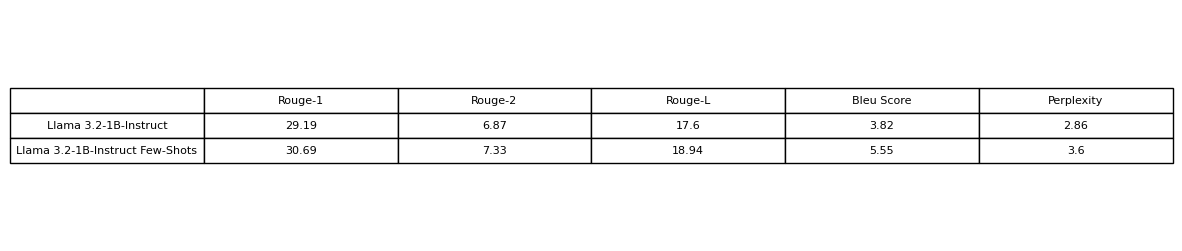

In [ ]:
data = [
    ["", "Rouge-1", "Rouge-2", "Rouge-L", "Bleu Score", "Perplexity"],  
    ["Llama 3.2-1B-Instruct", 29.19, 6.87, 17.60, 3.82, 2.86],
    ["Llama 3.2-1B-Instruct Few-Shots", 30.69, 7.33, 18.94, 5.55, 3.60],
]

fig, ax = plt.subplots(figsize=(5, 3))
ax.axis("off")  

table = ax.table(cellText=data, loc="center", cellLoc="center", colLoc="center")

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(3, 1.5)

plt.show()

The results show that few-shot learning provides an advantage in terms of accuracy and relevance (Rouge and BLEU scores). Although the difference is marginal, the model produces more detailed abstracts that closely align with the style of real scientific abstracts. While perplexity increases slightly, the impact is minimal and is outweighed by the overall gain in text quality.

We can conclude that for this task, the use of few-shot learning appears beneficial, enhancing the quality of the abstracts without significantly compromising fluency.